In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import awkward as ak
import mplhep as hep
import vector
hep.style.use("CMS")

In [2]:
data_directory = "/global/homes/r/rmilton/m3246/rmilton/H1Unfold/jet_data/"
file_name = "kt_rapgap_jets.root"
with ur.open("{file}:jets".format(file=data_directory+file_name)) as out:
    jets = out.arrays(["eta", "px", "py", "pz", "E", "pT", "phi"])
    print("Number of events:",out.num_entries)
with ur.open("{file}:event".format(file=data_directory+file_name)) as event:
    event_info = event.arrays(["Q2", "y", "elec_pT","elec_eta","elec_phi", "weight", "unfolded_weights"])
    print("Number of events:",event.num_entries)

Number of events: 293799
Number of events: 293799


In [3]:
data_directory = "/global/homes/r/rmilton/m3246/rmilton/H1Unfold/jet_data/"
file_name = "H1_kt_lab_jets.root"
with ur.open("{file}:jets".format(file=data_directory+file_name)) as out:
    data_jets = out.arrays(["eta", "px", "py", "pz", "E", "pT", "phi"])
    print("Number of events:",out.num_entries)
with ur.open("{file}:event".format(file=data_directory+file_name)) as event:
    data_event_info = event.arrays(["Q2", "y", "elec_pT","elec_eta","elec_phi", "weight"])
    print("Number of events:",event.num_entries)

Number of events: 213702
Number of events: 213702


In [4]:
# jet_mask = (event_info["y"] > .08) & (event_info["y"] < 0.7) & (event_info["Q2"] > 150) & (jets["pT"] > 10) & (jets["eta"] > -1) & (jets["eta"] < 2.5)
jet_mask = (event_info["y"] > .08) & (event_info["y"] < 0.7) & (event_info["Q2"] > 150)& (jets["pT"] > 0)
data_jet_mask = (data_event_info["y"] > .08) & (data_event_info["y"] < 0.7) & (data_event_info["Q2"] > 150)& (data_jets["pT"] > 0)
print(len(jets["pT"]),len(jets["pT"][jet_mask]))
# jet_mask = np.full(len(jets["pT"]), True)


293799 219554


In [5]:
paper_pT = [12.3390, 18.1112, 26.5836, 39.01933, 57.27255, 84.064603]
paper_pT_cross_section = [.1147, .0439, .0112, .00245, .00048, .000064]
paper_eta = [-.650, .050, .750, 1.4500, 2.1500]
paper_eta_cross_section = [.337, .605, .331, .1096, .0444]
paper_qTQ = [.03, .102, .21, .389, .716, 1.2988, 2.3359]
paper_qTQ_cross_section = [3.51, 3.207, 1.65, .691, .223, .0705, .0059]
paper_deltaphi = [.03, .077, .14, .26, .440, .741, 1.2343]
paper_deltaphi_cross_section = [5.93, 3.622, 2.03, 1.02, .431, .161, .0640]

In [6]:
def get_binning(centers):
    edges = []
    for i, center in enumerate(centers):
        if i == 0:
            first_bin_spacing = centers[i+1] - center
            edges.append(center - first_bin_spacing/2)
            edges.append(center + first_bin_spacing/2)
        else:
            bin_edge =  2 * (center - edges[-1]/2)
            edges.append(bin_edge)
    return np.array(edges)

In [7]:
pT_binning = get_binning(paper_pT)
eta_binning = get_binning(paper_eta)
qTQ_binning = get_binning(paper_qTQ)
deltaphi_binning = get_binning(paper_deltaphi)

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

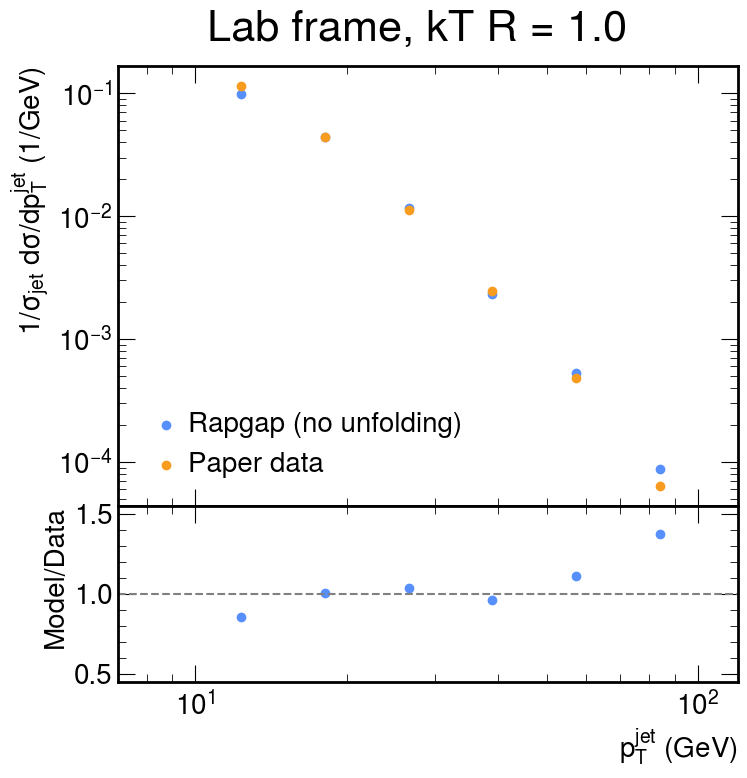

In [17]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)

xlow, xhigh = 7, 120
n,bins = np.histogram(jets["pT"][jet_mask], weights = event_info["weight"][jet_mask], density=True, bins = pT_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")
axs[0].scatter(paper_pT, paper_pT_cross_section, label="Paper data")

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(xlow, xhigh)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/dp_T^{jet}~(1/GeV)$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)


axs[1].scatter(paper_pT, n/paper_pT_cross_section)
axs[1].set_ylabel("Model/Data", fontsize=20)
axs[1].set_ylim(0.45, 1.55)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed' )
plt.xlabel("$p^{jet}_T$ (GeV)", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

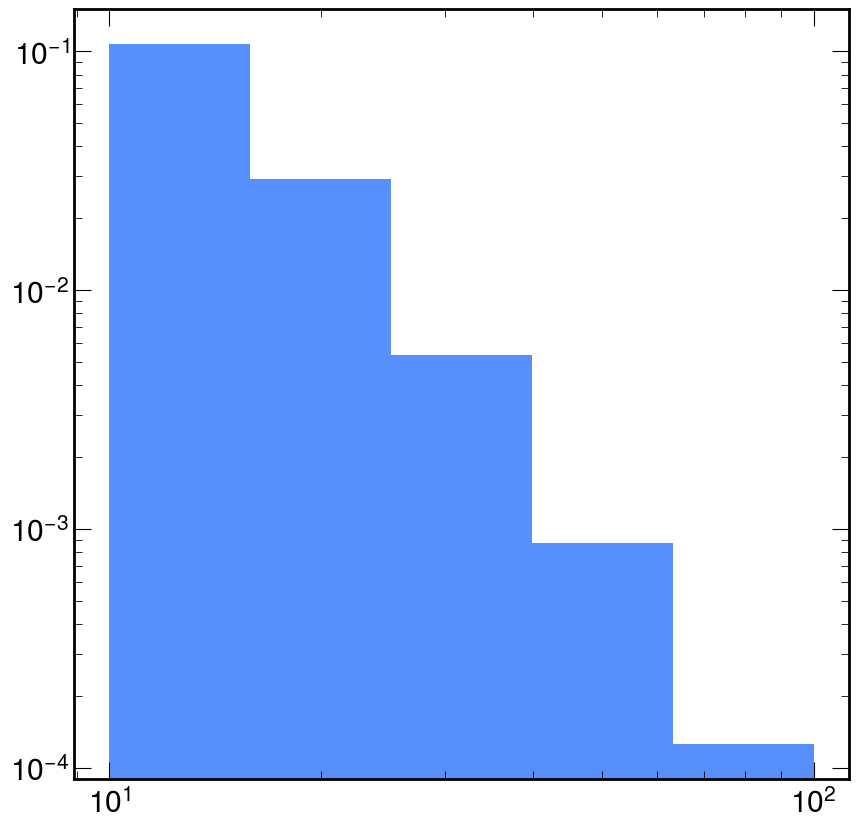

In [9]:
binning = np.geomspace(10,100,6)
plt.hist(jets["pT"][jet_mask], weights = event_info["weight"][jet_mask], density=True, bins = binning)
plt.xscale('log')
plt.yscale('log')

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

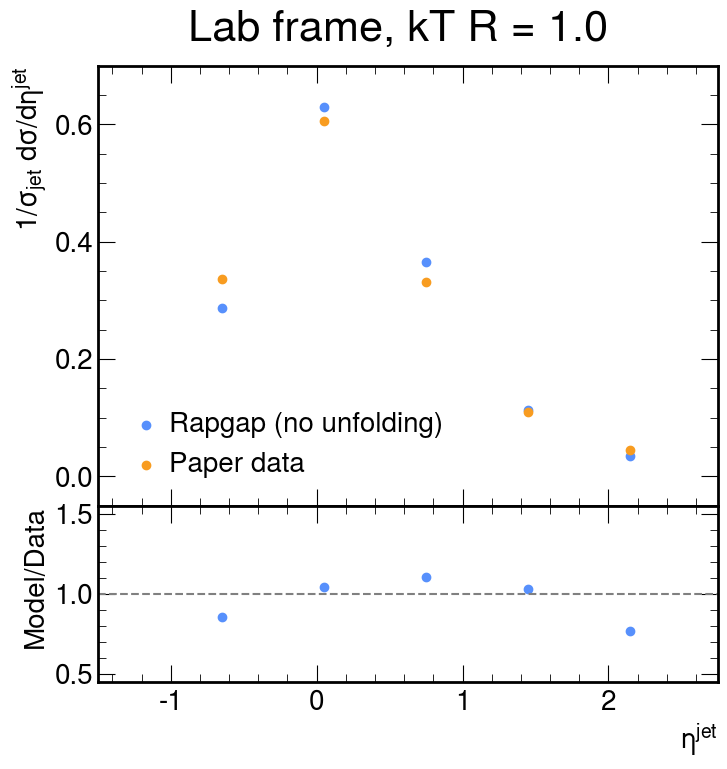

In [16]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)

xlow, xhigh = -1.5, 2.75
n,bins = np.histogram(jets["eta"][jet_mask], weights = event_info["weight"][jet_mask]*event_info["unfolded_weights"][jet_mask], density=True, bins = eta_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")

axs[0].scatter(paper_eta, paper_eta_cross_section, label="Paper data")

axs[0].set_xlim(-1.5,2.75)
axs[0].set_ylim(-.05,.7)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/d\eta^{jet}$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)

axs[1].scatter(paper_eta, n/paper_eta_cross_section)
axs[1].set_ylabel("Model/Data", fontsize=20)
axs[1].set_ylim(0.45, 1.55)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed')
plt.xlabel("$\eta^{jet}$", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

(array([0.23679044, 0.57194613, 0.66791641, 0.33873385, 0.13091152,
        0.05370169]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <BarContainer object of 6 artists>)

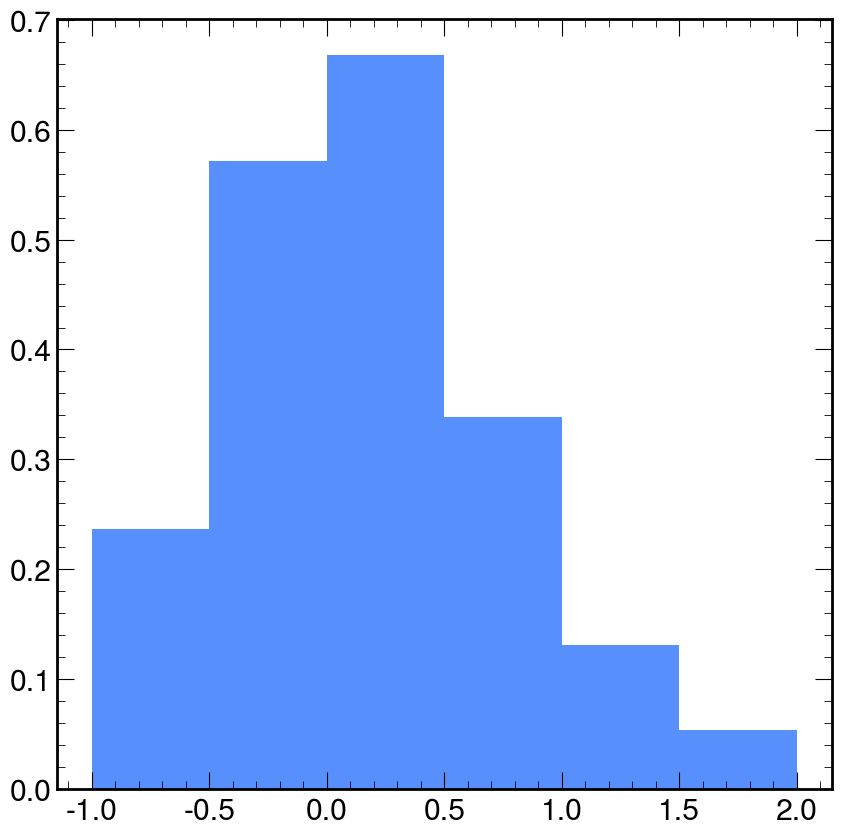

In [11]:
binning = np.linspace(-1,2.,7)
plt.hist(jets["eta"][jet_mask], weights = event_info["weight"][jet_mask], density=True, bins = binning)

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

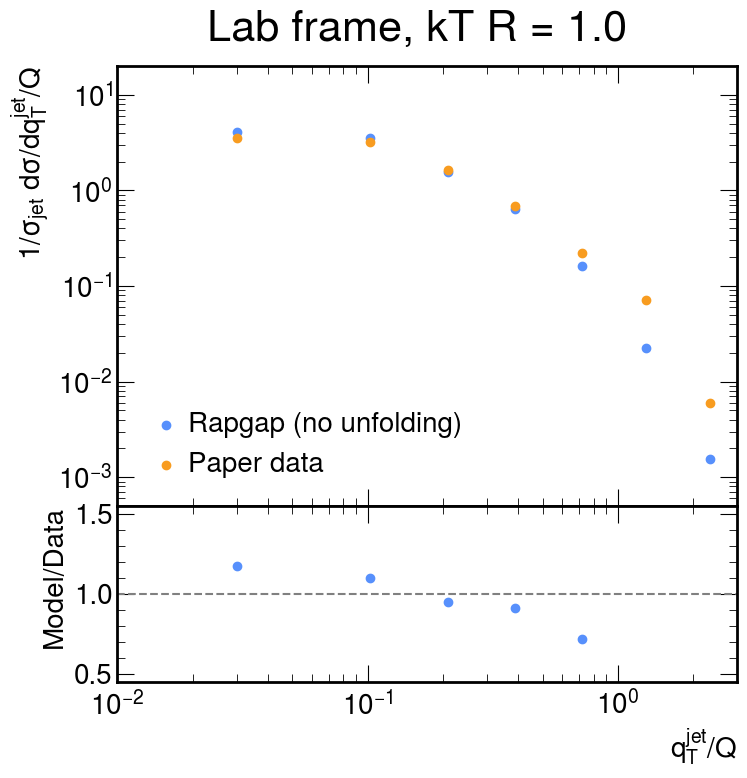

In [12]:
qTjet = np.sqrt((jets["px"][jet_mask] + event_info["elec_pT"][jet_mask]*np.cos(event_info["elec_phi"][jet_mask]))**2 + (jets["py"][jet_mask] + event_info["elec_pT"][jet_mask]*np.sin(event_info["elec_phi"][jet_mask]))**2)
qTQjet = qTjet/np.sqrt(event_info["Q2"][jet_mask])

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)
xlow, xhigh = .01, 3

n,bins = np.histogram(qTQjet, weights = event_info["weight"][jet_mask], density=True, bins = qTQ_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")
axs[0].scatter(paper_qTQ, paper_qTQ_cross_section, label="Paper data")

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(5e-4,20)
axs[0].set_xlim(xlow, xhigh)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/dq_T^{jet}/Q$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)

axs[1].set_xscale('log')
axs[1].scatter(paper_qTQ, n/paper_qTQ_cross_section)
axs[1].set_ylabel("Model/Data", fontsize=20)
axs[1].set_ylim(0.45, 1.55)
axs[1].set_xlim(xlow, xhigh)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed')

plt.xlabel("$q_T^{jet}/Q$", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

(0.01, 20)

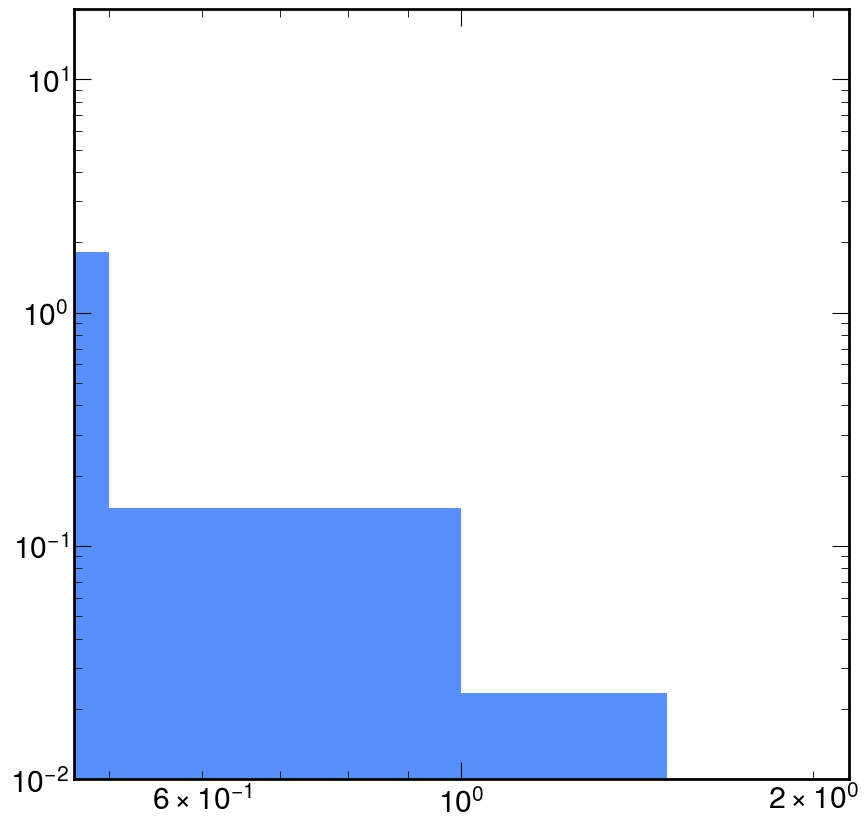

In [13]:
qTjet = np.sqrt((jets["px"][jet_mask] + event_info["elec_pT"][jet_mask]*np.cos(event_info["elec_phi"][jet_mask]))**2 + (jets["py"][jet_mask] + event_info["elec_pT"][jet_mask]*np.sin(event_info["elec_phi"][jet_mask]))**2)
qTQjet = qTjet/np.sqrt(event_info["Q2"][jet_mask])
plt.hist(qTQjet,  weights = event_info["weight"][jet_mask], density=True, bins = binning)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,20)

Text(0.5, 0.95, 'Lab frame, kT R = 1.0')

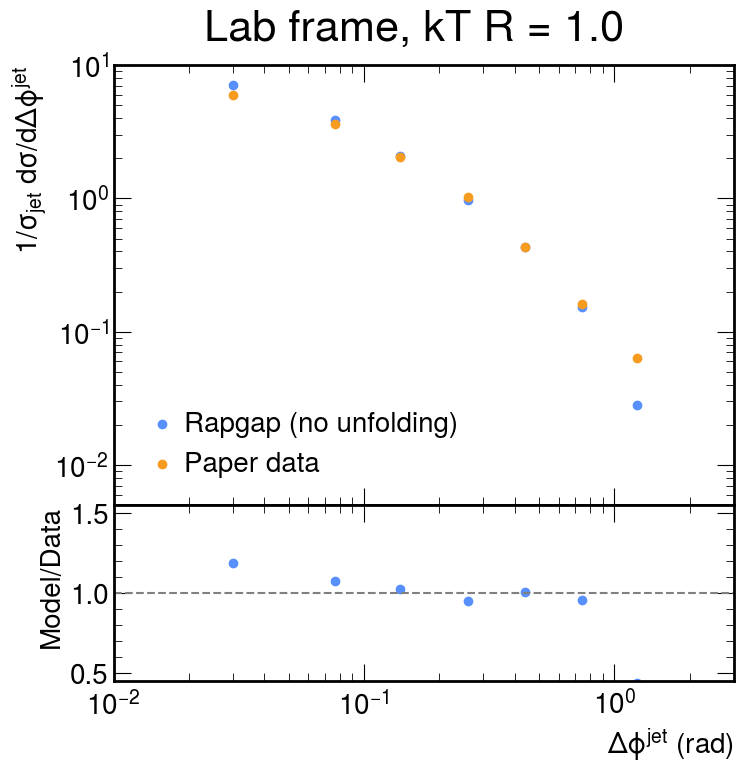

In [14]:
delta_phi = np.absolute(np.pi + jets["phi"][jet_mask] - event_info["elec_phi"][jet_mask])
delta_phi = np.where(delta_phi > 2 * np.pi, delta_phi - 2 * np.pi, delta_phi)

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2.5, 1])
axs = gs.subplots(sharex=True)
xlow, xhigh = .01, 3

n,bins = np.histogram(delta_phi, weights = event_info["weight"][jet_mask], density=True, bins = deltaphi_binning)
axs[0].scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, label="Rapgap (no unfolding)")

axs[0].scatter(paper_deltaphi, paper_deltaphi_cross_section, label="Paper data")

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(5e-3,10)
axs[0].set_xlim(xlow, xhigh)
axs[0].set_ylabel("$1/\sigma_{jet}~d\sigma/d\Delta \phi^{jet}$", fontsize=20)
axs[0].legend(loc='lower left', handletextpad=0.05, fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].tick_params(axis='both', which='minor', labelsize=20)

axs[1].set_xscale('log')
axs[1].scatter(paper_deltaphi, n/paper_deltaphi_cross_section)
axs[1].set_ylabel("Model/Data", fontsize=20)
axs[1].set_ylim(0.45, 1.55)
axs[1].set_xlim(xlow, xhigh)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].hlines(1, xlow, xhigh, color='grey', linestyle='dashed')

plt.xlabel("$\Delta \phi^{jet} ~(rad)$", fontsize=20)

plt.suptitle("Lab frame, kT R = 1.0", y=0.95)

(0.01, 50)

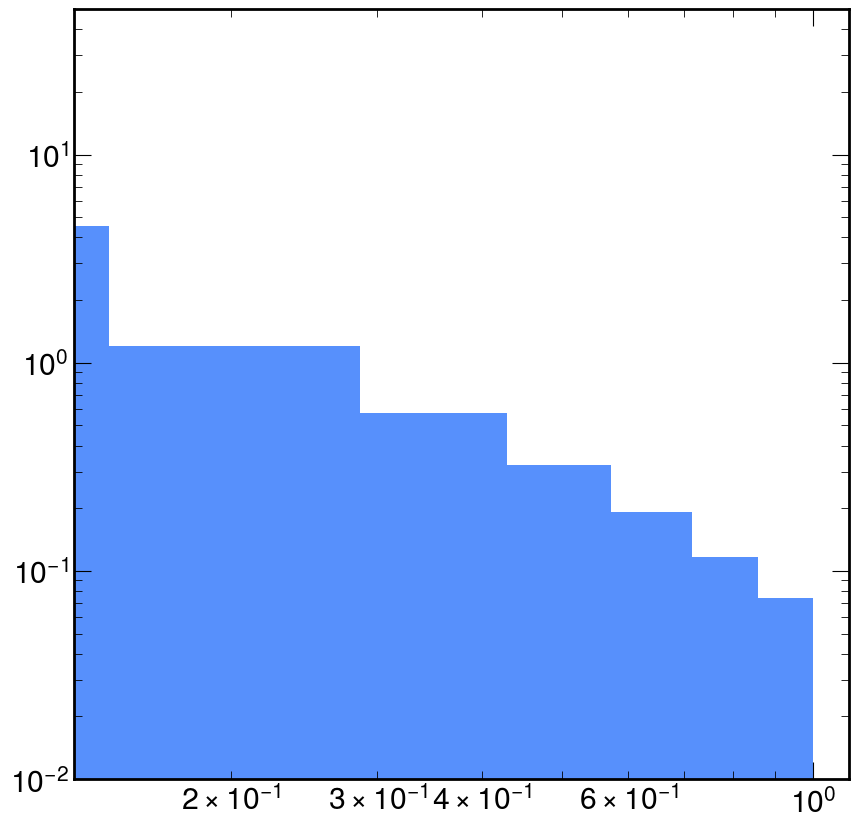

In [15]:
binning = np.linspace(0,1,8)
plt.hist(delta_phi, weights = event_info["weight"][jet_mask], density=True, bins = binning)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,50)